1. Como criar uma rede neural com pytorch   

In [16]:
import torch
import numpy as np
from torch import nn

In [17]:
#criando uma classe com class: o que é uma classe? -> Classes são uma parte fundamental da programação orientada a objetos em Python. Elas nos permitem criar estruturas e organizar nosso código de forma modular e reutilizável

class LineNetwork (nn.Module):
    #inicialização
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1,1)
        )

    #como a rede computa
    def forward(self, x):
        return self.layers(x)


2. Como criar um DataSet com pytorch

3. Como treinar uma rede neural com pytorch

3.1. Criando a infraestrutura dos dados

In [18]:
from torch.utils.data import Dataset, DataLoader
import torch.distributions.uniform as urand

In [19]:
#classe que representa nosso conjunto de dados
class AlgebraicDataset(Dataset):
    def __init__ (self, f, interval, nsamples):
        X = urand.Uniform(interval[0], interval[1]).sample([nsamples])
        self.data = [(x, f(x)) for x in X] 

    def __len__ (self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [20]:
line = lambda x: 2*x + 3
interval = (-10, 10)
train_nsamples = 1000
test_nsamples = 100

In [21]:
train_dataset = AlgebraicDataset(line, interval,train_nsamples)
test_dataset = AlgebraicDataset(line, interval, test_nsamples)

train_dataloader = DataLoader(train_dataset, batch_size=train_nsamples, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_nsamples, shuffle=True)


3.2 Hiperparâmetros de otimização

In [22]:
#verificar se tem um gpu disponivel 
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Rodando na {device}")

Rodando na cpu


In [23]:
#criando a rede a partir da classe e alocando no dispositivo
model = LineNetwork().to(device)

In [24]:
#função de perda, loss function. Erro quadrático médio
lossfunc = nn.MSELoss()
#SGD = Stochastic Gradient Descent
#lr = learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)


In [25]:
def train(model, dataloader, lossfunc, optimizer):
    model.train()
    cumloss = 0.0
    for X, y in dataloader:
        X = X.unsqueeze(1).float().to(device)
        y = y.unsqueeze(1).float().to(device)

        pred = model(X)
        loss = lossfunc(pred, y)
        
        #zera os gradientes acumulados
        optimizer.zero_grad()
        # computa os gradientes
        loss.backward()
        # anda, de fato, na direção que reduz o erro local
        optimizer.step()


        #loss é um tensor; item pra obter o float
        cumloss += loss.item()

    return cumloss/len(dataloader)


def test(model, dataloader, lossfunc):
    model.eval()

    cumloss = 0.0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.unsqueeze(1).float().to(device)
            y = y.unsqueeze(1).float().to(device)

            pred = model(X)
            loss = lossfunc(pred, y)
            cumloss += loss.item()

    return cumloss/len(dataloader)

3.3 Treinando a rede de fato

In [26]:
import matplotlib.pyplot as plt

In [27]:
# Para visualizar
def plot_comparinson(f, model, interval=(-10, 10), nsamples=10):
    fig, ax = plt.subplots(figsize=(10, 10))

    ax.grid(True, which='both')
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')

    samples = np.linspace(interval[0], interval[1], nsamples)
    model.eval()
    with torch.no_grad():
        pred = model(torch.tensor(samples).unsqueeze(1).float().to(device))

    ax.plot(samples, list(map(f, samples)), "o", label="ground truth")
    ax.plot(samples, pred.cpu(), label="model")
    plt.legend()
    plt.show()


Epoch: 0; Train Loss: 90.5219497680664


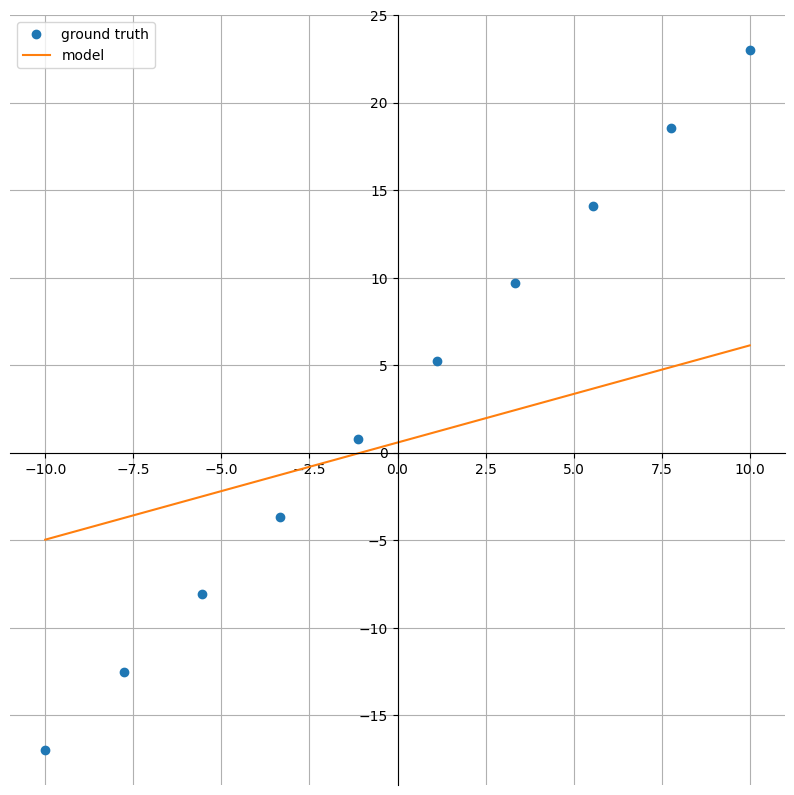

Epoch: 10; Train Loss: 25.369062423706055


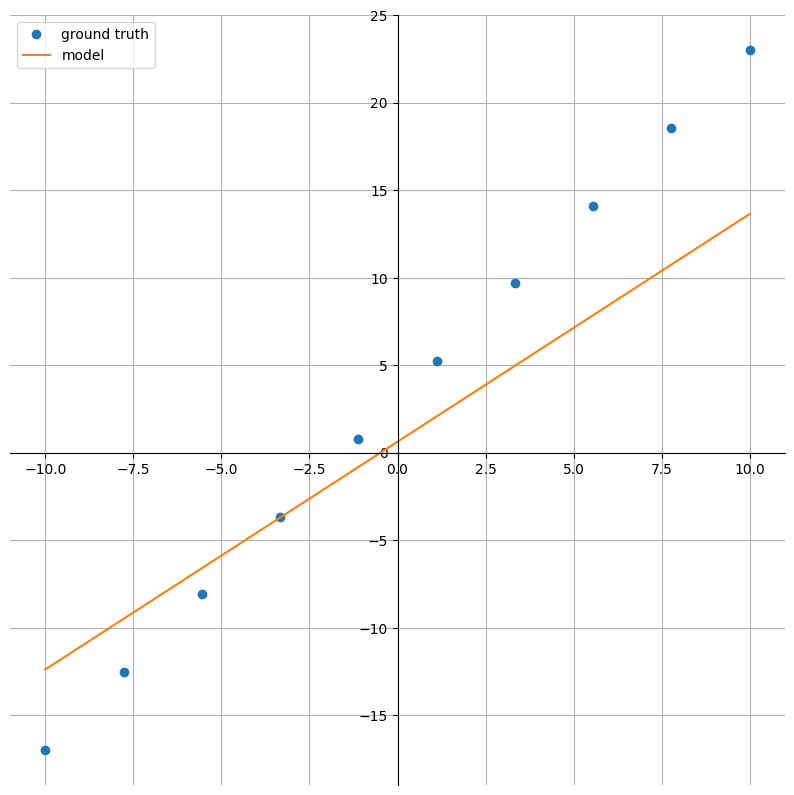

Epoch: 20; Train Loss: 10.053069114685059


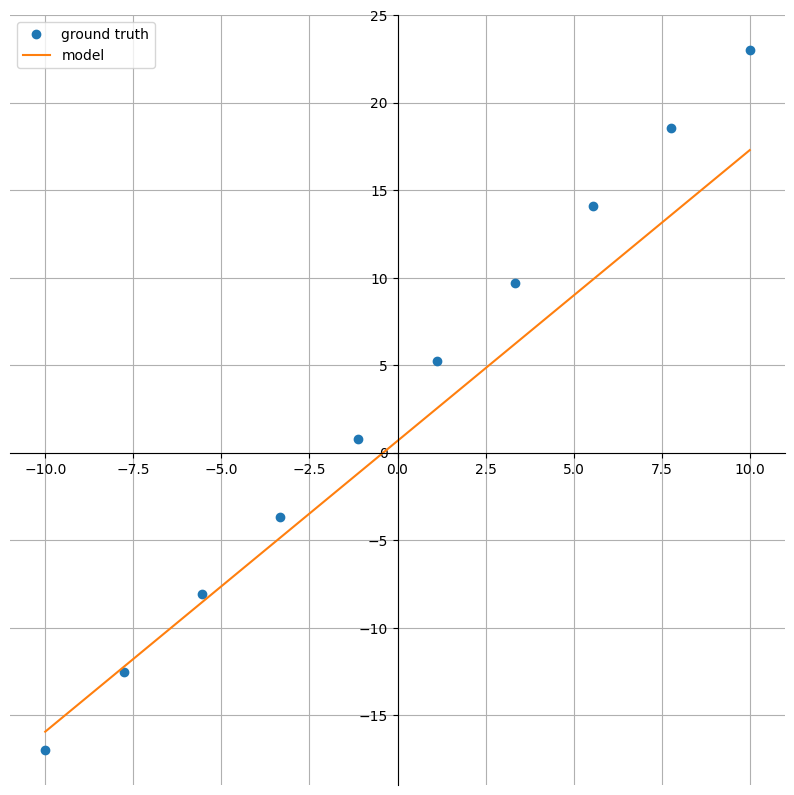

Epoch: 30; Train Loss: 6.329436302185059


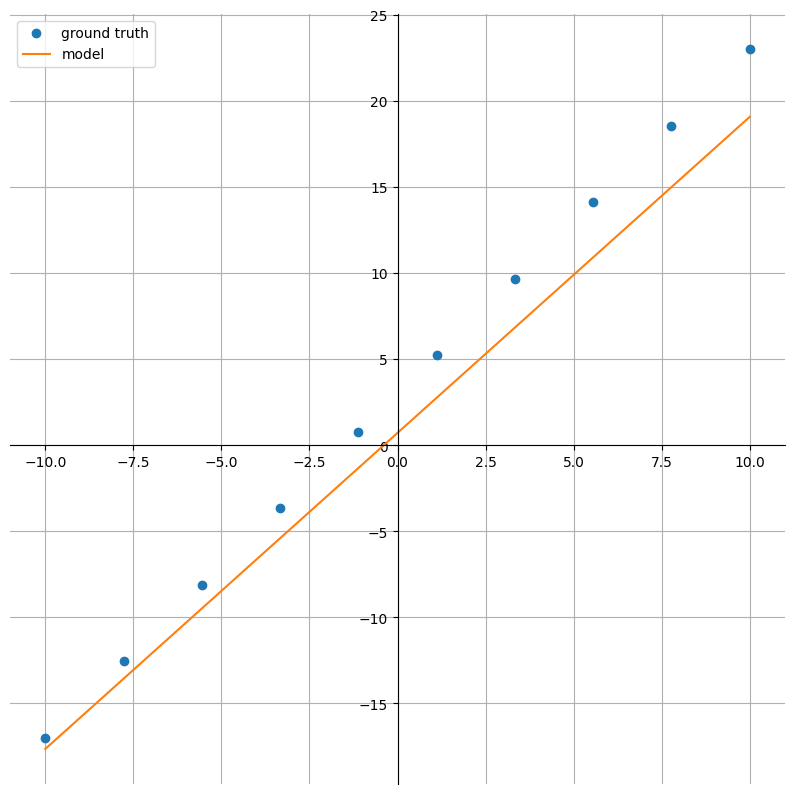

Epoch: 40; Train Loss: 5.307106971740723


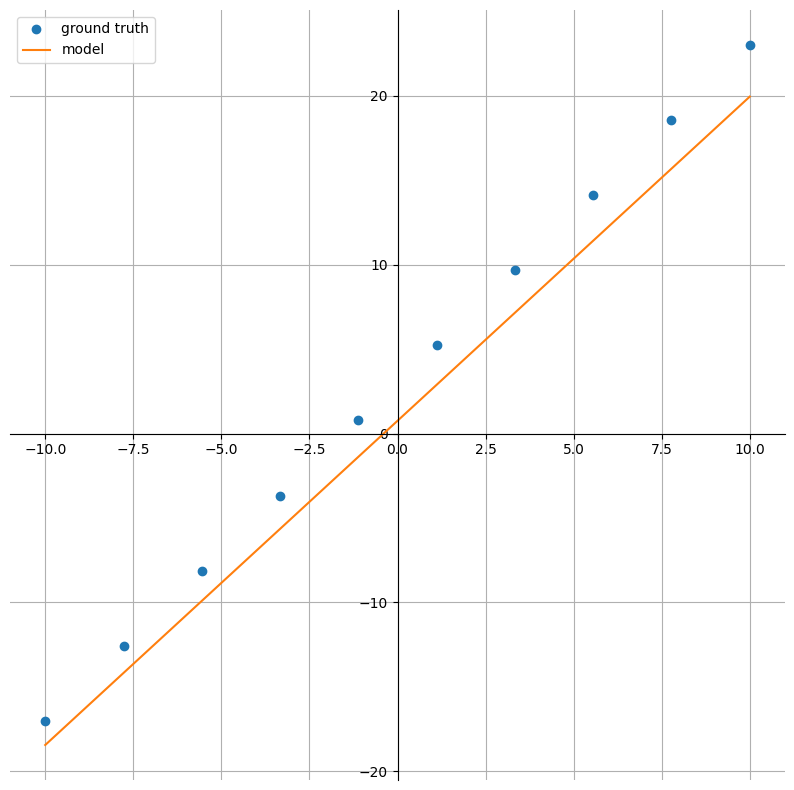

Epoch: 50; Train Loss: 4.918906211853027


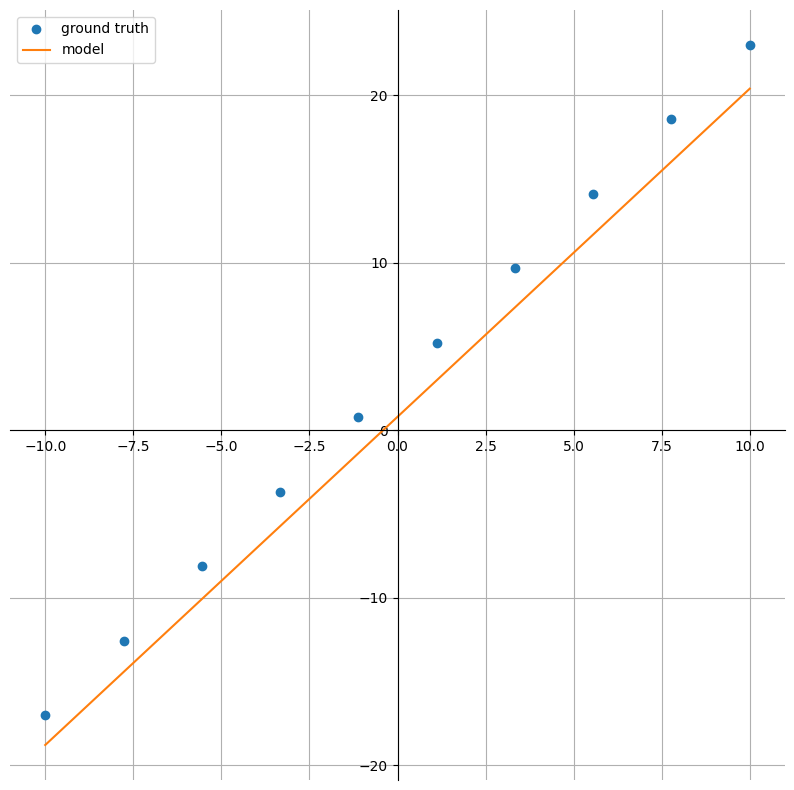

Epoch: 60; Train Loss: 4.6840314865112305


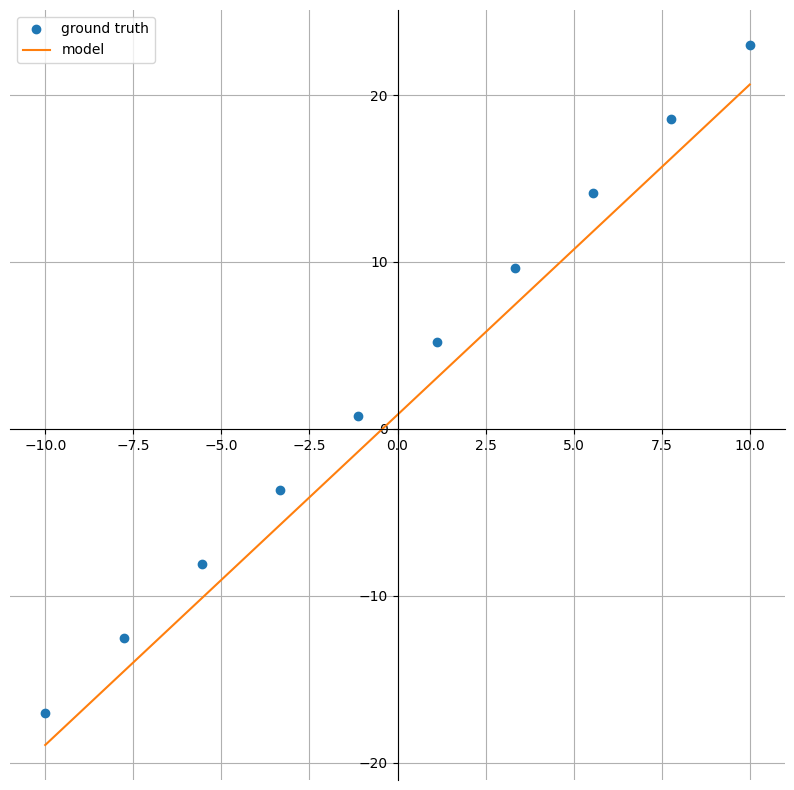

Epoch: 70; Train Loss: 4.490474700927734


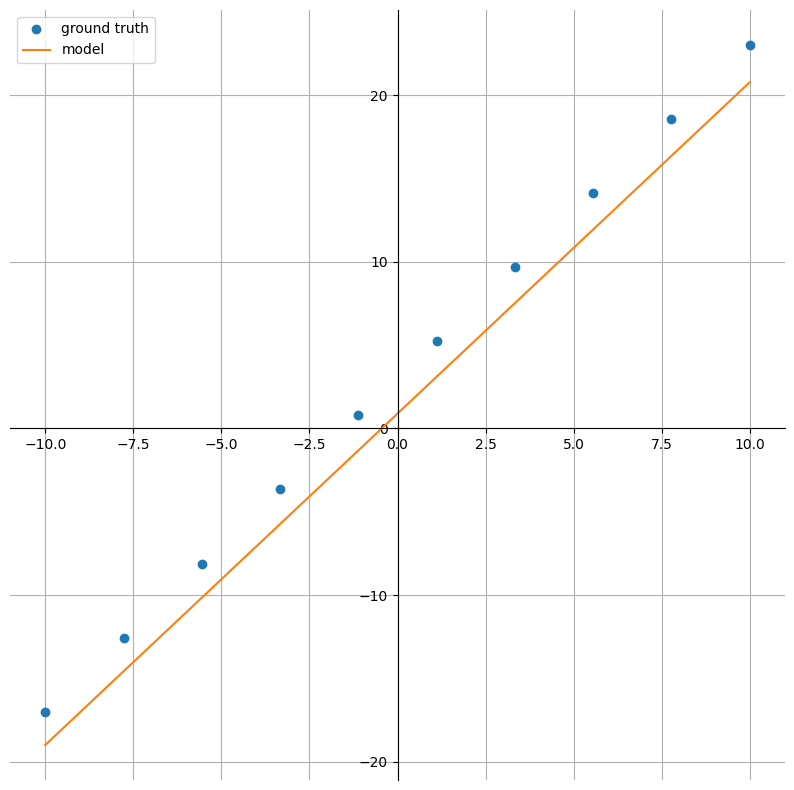

Epoch: 80; Train Loss: 4.311979293823242


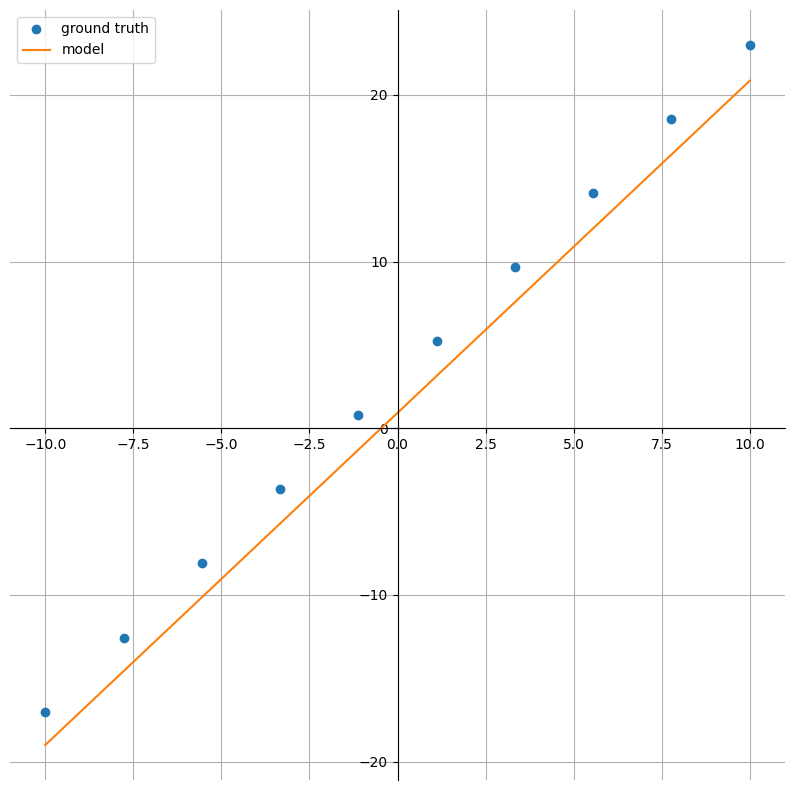

Epoch: 90; Train Loss: 4.142223358154297


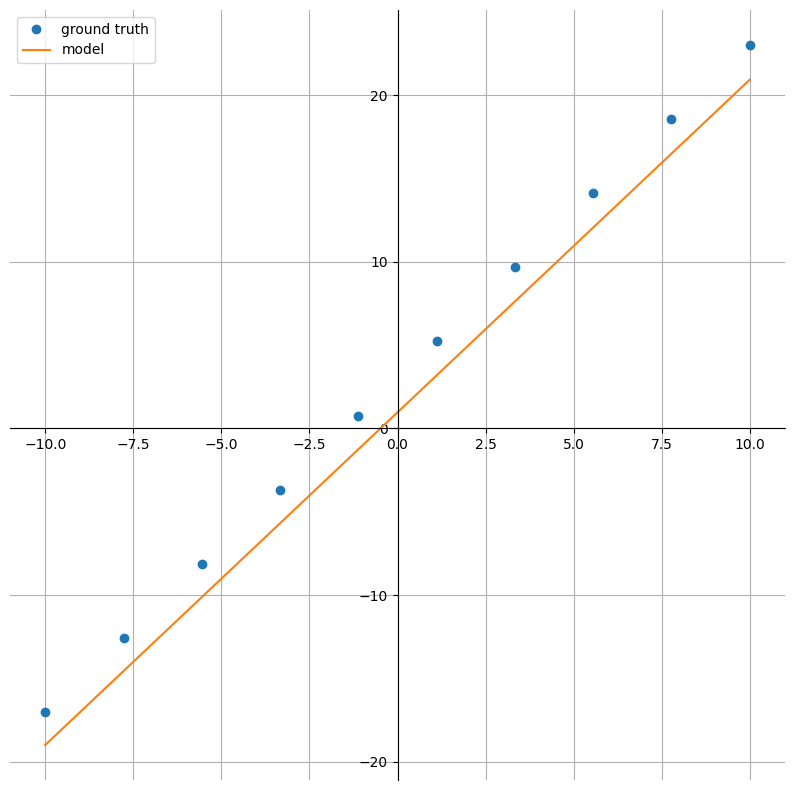

Epoch: 100; Train Loss: 3.9795331954956055


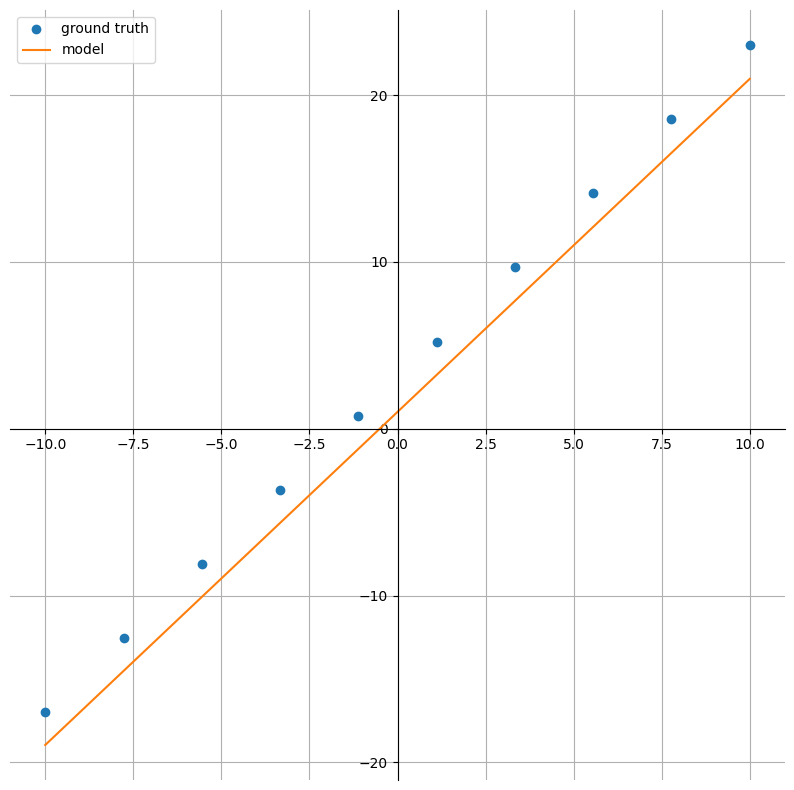

Epoch: 110; Train Loss: 3.8233213424682617


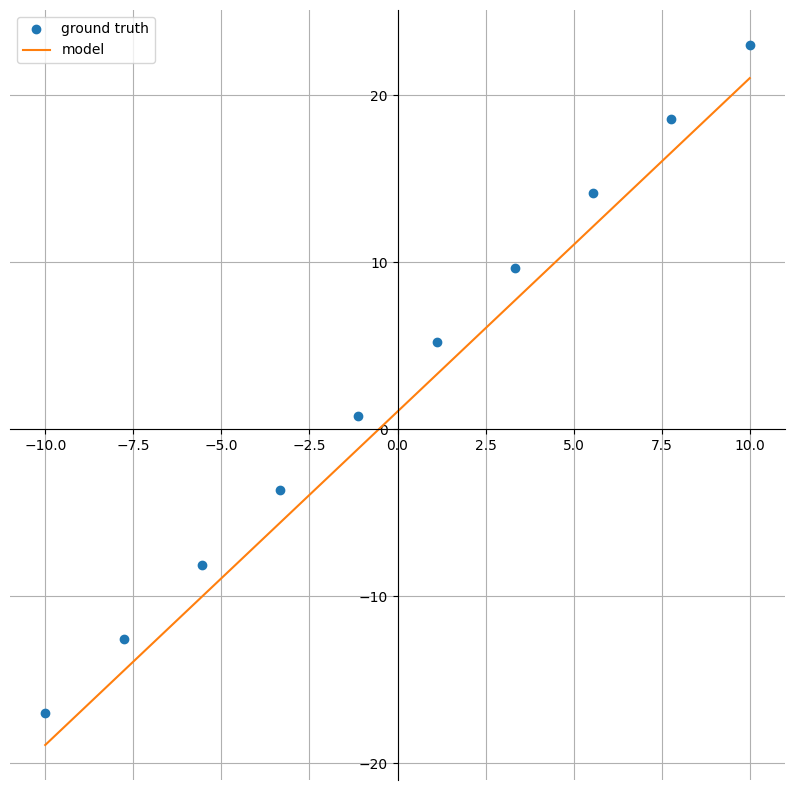

Epoch: 120; Train Loss: 3.673264265060425


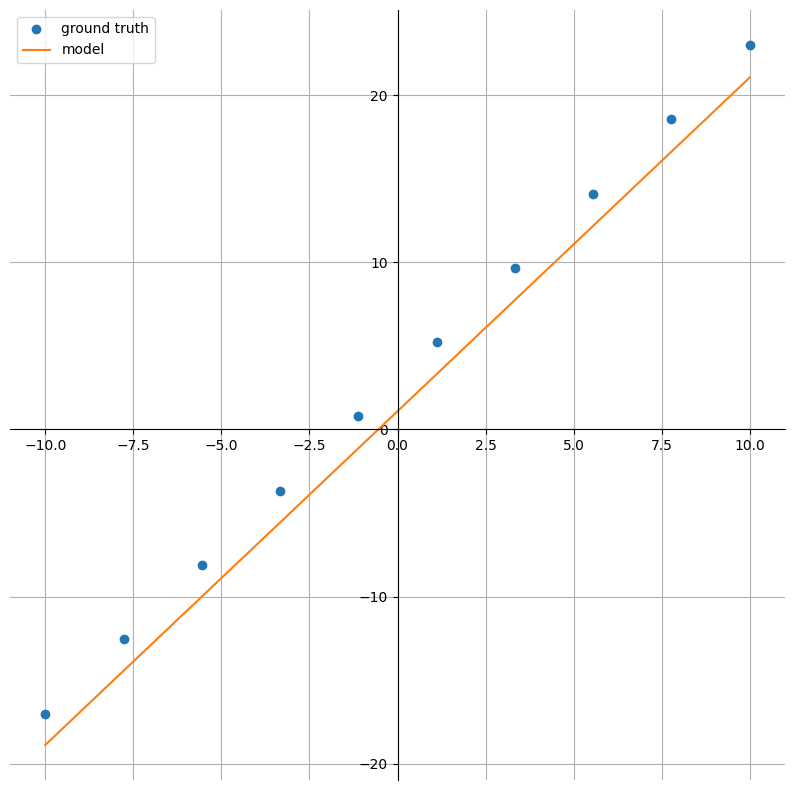

Epoch: 130; Train Loss: 3.529099225997925


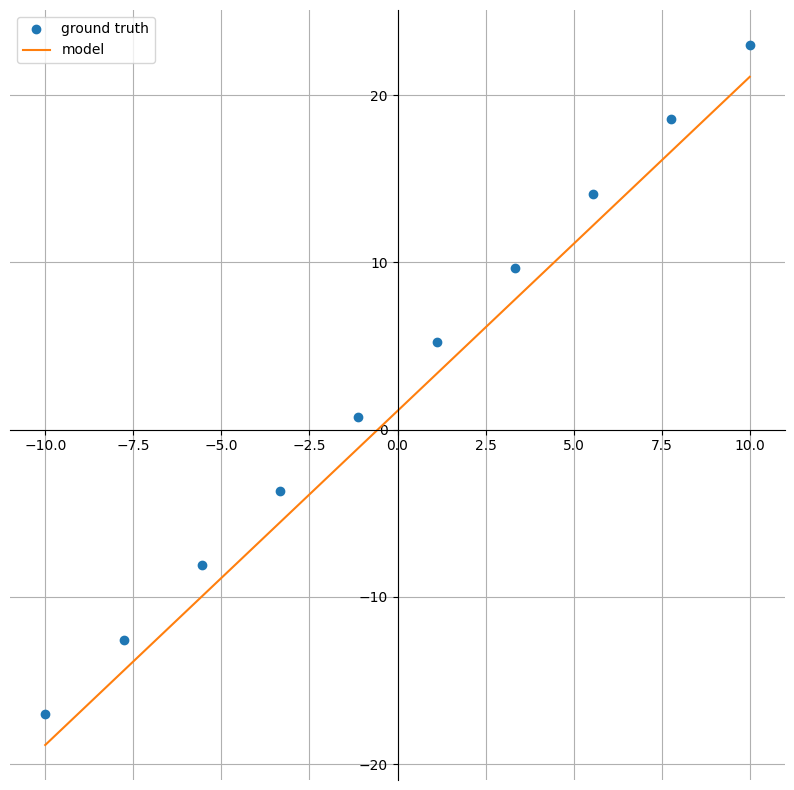

Epoch: 140; Train Loss: 3.3905932903289795


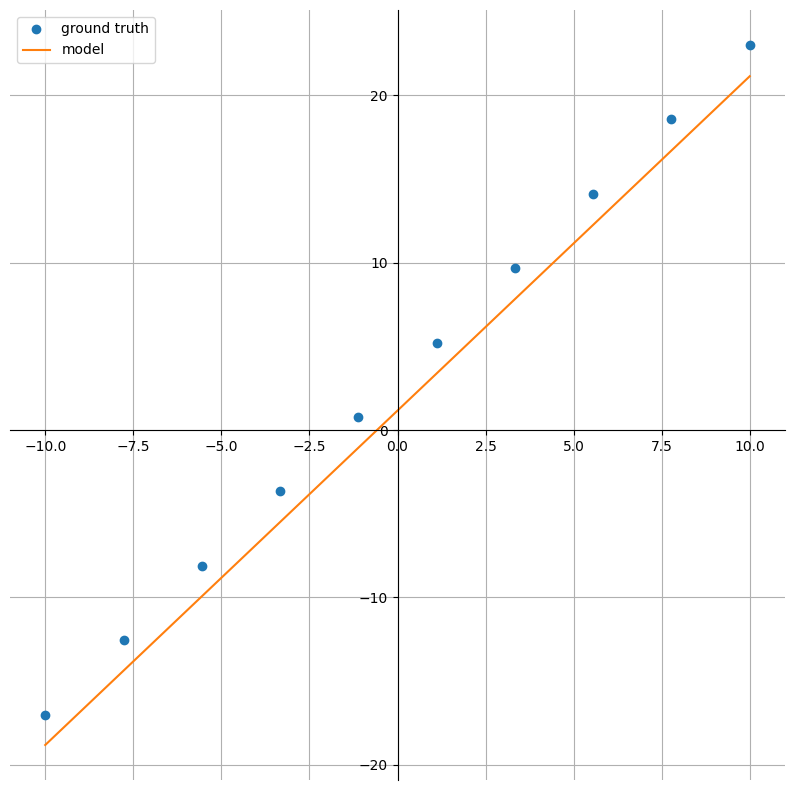

Epoch: 150; Train Loss: 3.2575247287750244


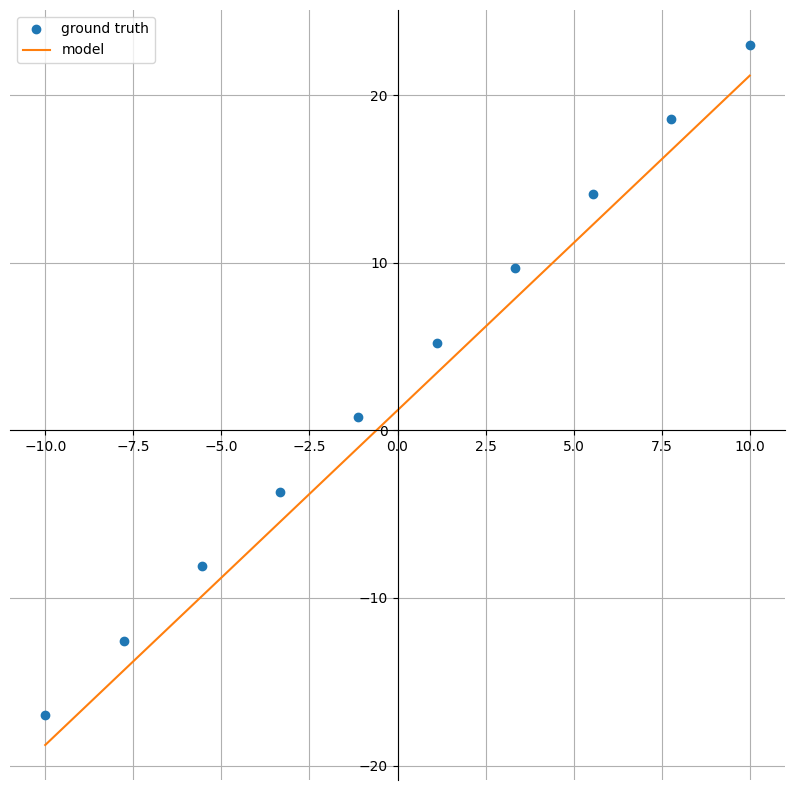

Epoch: 160; Train Loss: 3.1296775341033936


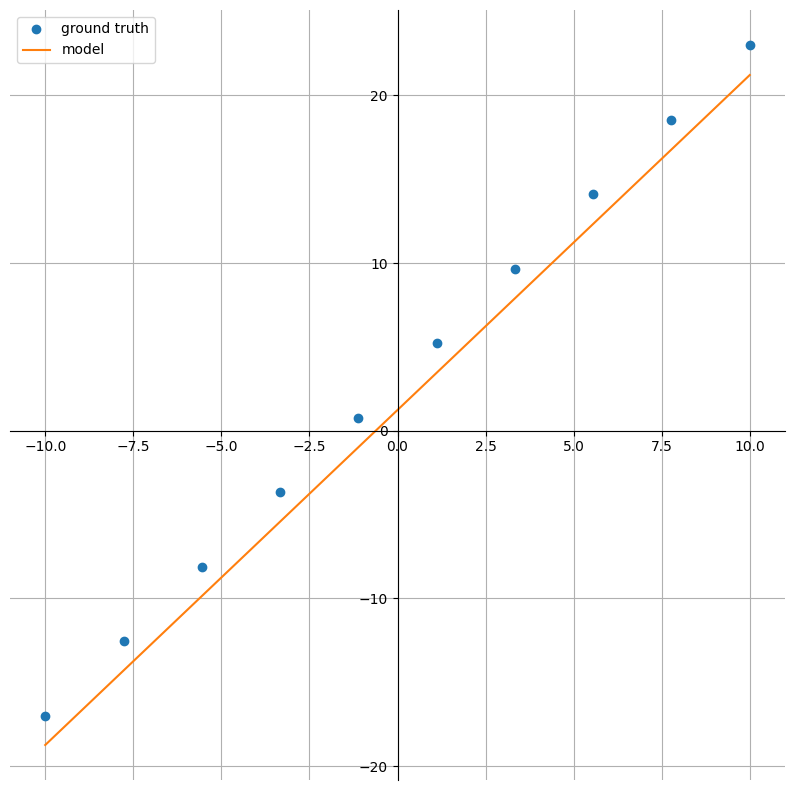

Epoch: 170; Train Loss: 3.0068490505218506


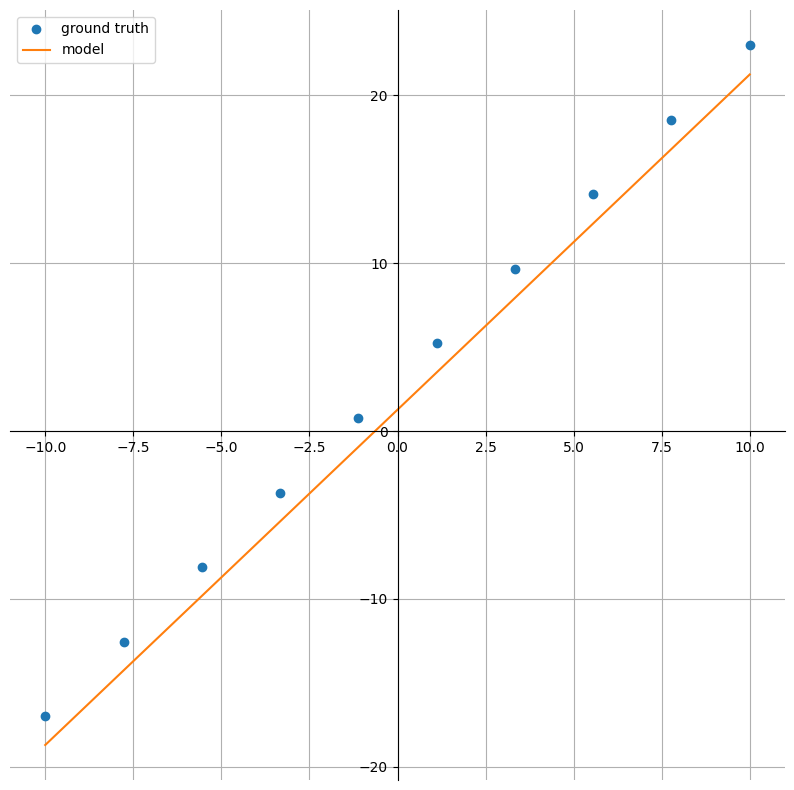

Epoch: 180; Train Loss: 2.8888401985168457


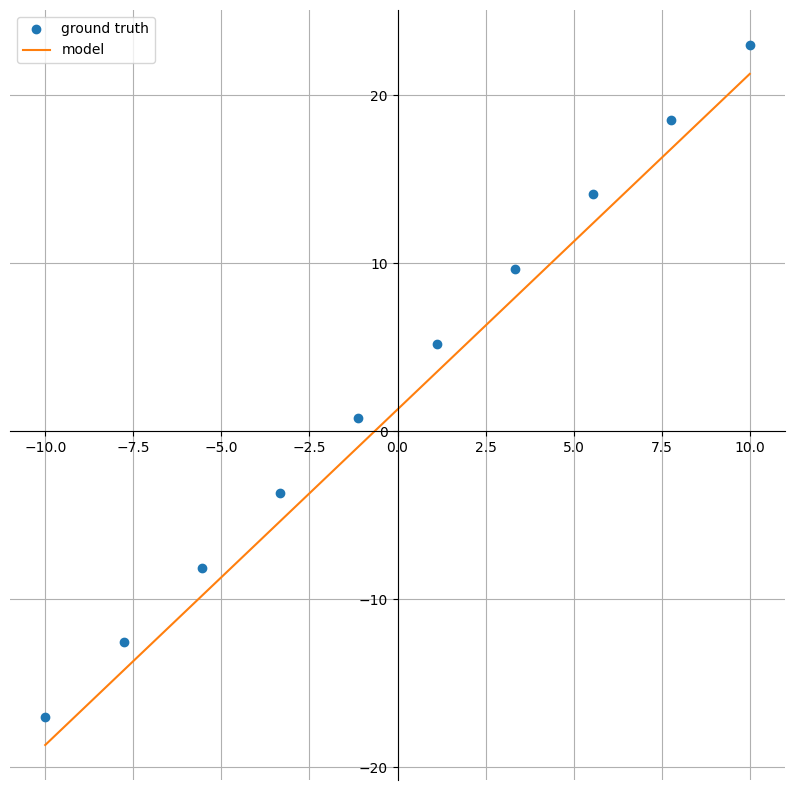

Epoch: 190; Train Loss: 2.7754628658294678


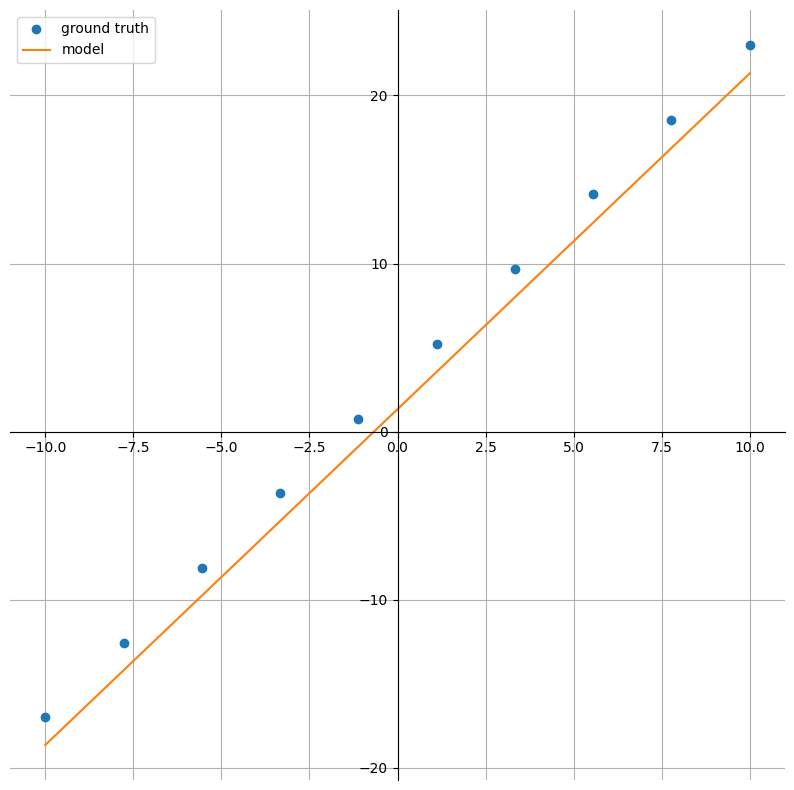

Epoch: 200; Train Loss: 2.6665351390838623


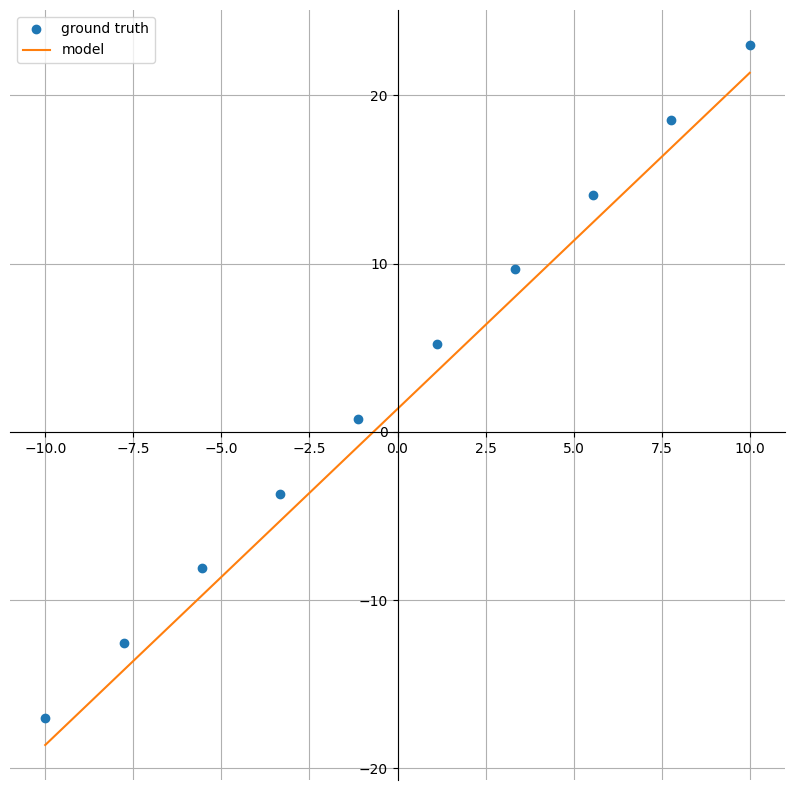

Test Loss: 2.6507973670959473


In [28]:
epochs = 201
for t in range(epochs):
    train_loss = train(model, train_dataloader, lossfunc, optimizer)
    if t % 10 == 0:
        print(f"Epoch: {t}; Train Loss: {train_loss}")
        plot_comparinson(line, model)
test_loss = test(model, test_dataloader, lossfunc)
print(f"Test Loss: {test_loss}")